## **Klasifikasi Kualitas Udara DKI Jakarta Menggunakan Metode Support Vector Machine dengan Optimasi Hyperparameter Gridseacrh CV**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.cm as cm

In [2]:
df = pd.read_excel('Data ISPU.xlsx')
data = pd.DataFrame(df)
df

,Tanggal,KabKota,CO,NO2,O3,PM10,PM2.5,SO2,Max,Critical,Kategori
0,2018-01-01,KEPULAUAN SERIBU,1.730000,2.428571,12.380952,31.70,57.894737,2.417582,57.894737,PM2.5,SEDANG
1,2018-01-01,KOTA JAKARTA BARAT,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,71.804511,PM2.5,SEDANG
2,2018-01-01,KOTA JAKARTA PUSAT,2.615714,4.857143,12.476190,47.20,71.929825,4.505495,71.929825,PM2.5,SEDANG
3,2018-01-01,KOTA JAKARTA SELATAN,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,71.804511,PM2.5,SEDANG
4,2018-01-01,KOTA JAKARTA TIMUR,3.745714,5.142857,18.857143,57.35,87.468672,5.384615,87.468672,PM2.5,SEDANG
...,...,...,...,...,...,...,...,...,...,...,...
9847,2022-06-30,KOTA JAKARTA BARAT,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,115.789474,PM2.5,TIDAK SEHAT
9848,2022-06-30,KOTA JAKARTA PUSAT,7.762857,13.428571,27.095238,75.15,115.894737,11.428571,115.894737,PM2.5,TIDAK SEHAT
9849,2022-06-30,KOTA JAKARTA SELATAN,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,115.789474,PM2.5,TIDAK SEHAT
9850,2022-06-30,KOTA JAKARTA TIMUR,9.004286,13.214286,27.428571,84.85,130.210526,11.868132,130.210526,PM2.5,TIDAK SEHAT


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9852 entries, 0 to 9851
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Tanggal   9852 non-null   datetime64[ns]
 1   KabKota   9852 non-null   object        
 2   CO        9852 non-null   float64       
 3   NO2       9852 non-null   float64       
 4   O3        9852 non-null   float64       
 5   PM10      9852 non-null   float64       
 6   PM2.5     9852 non-null   float64       
 7   SO2       9852 non-null   float64       
 8   Max       9852 non-null   float64       
 9   Critical  9852 non-null   object        
 10  Kategori  9852 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 846.8+ KB


### **Data Cleaning**

*Menghapus kolom yang tidak perlu*

menghapus kolom max dan critical karena parameter yang hasil pengukurannya paling tinggi dari pm10 sampai no2 yang bisa kita hitung sendiri nantinya dan menghapus kolom tanggal dan stasiun karena kategori berasal dari pm10 sampai no2.

In [4]:
df_cleaned = df.drop(columns=['Tanggal', 'KabKota', 'Max', 'Critical'])
df_cleaned

,CO,NO2,O3,PM10,PM2.5,SO2,Kategori
0,1.730000,2.428571,12.380952,31.70,57.894737,2.417582,SEDANG
1,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,SEDANG
2,2.615714,4.857143,12.476190,47.20,71.929825,4.505495,SEDANG
3,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,SEDANG
4,3.745714,5.142857,18.857143,57.35,87.468672,5.384615,SEDANG
...,...,...,...,...,...,...,...
9847,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,TIDAK SEHAT
9848,7.762857,13.428571,27.095238,75.15,115.894737,11.428571,TIDAK SEHAT
9849,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,TIDAK SEHAT
9850,9.004286,13.214286,27.428571,84.85,130.210526,11.868132,TIDAK SEHAT


### **Handling missing data**
Pada tahapan ini, akan dilakukan pengecheckan dataset apakah terdapat data yang bernilai null atau unknown. Ada beberapa strategi untuk menangani data yang bernilai null atau unknown, pada tugas ini saya memilih menghapus atau drop data yang bernilai null atau unknown karena jumlah record dataset yang dimiliki lumayan banyak.

In [5]:
# dalam dataset ini terdapat value kosong seperti "---", maka terlebih dahulu kita tanti dengan null
df_cleaned = df_cleaned.replace('---', np.nan)
df_cleaned = df_cleaned.replace('nan', np.nan)
df_cleaned = df_cleaned.replace('TIDAK ADA DATA', np.nan)

df_cleaned.isnull().sum()

CO          0
NO2         0
O3          0
PM10        0
PM2.5       0
SO2         0
Kategori    0
dtype: int64

In [6]:
df_cleaned

,CO,NO2,O3,PM10,PM2.5,SO2,Kategori
0,1.730000,2.428571,12.380952,31.70,57.894737,2.417582,SEDANG
1,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,SEDANG
2,2.615714,4.857143,12.476190,47.20,71.929825,4.505495,SEDANG
3,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,SEDANG
4,3.745714,5.142857,18.857143,57.35,87.468672,5.384615,SEDANG
...,...,...,...,...,...,...,...
9847,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,TIDAK SEHAT
9848,7.762857,13.428571,27.095238,75.15,115.894737,11.428571,TIDAK SEHAT
9849,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,TIDAK SEHAT
9850,9.004286,13.214286,27.428571,84.85,130.210526,11.868132,TIDAK SEHAT


### **Handling (drop) outliers**
Handling (drop) outliers yang digunakan yaitu menggunakan Z-scores dengan outliers_threshold = 3, dimana jika hasil Z-scores >=3 akan di drop.

D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=f

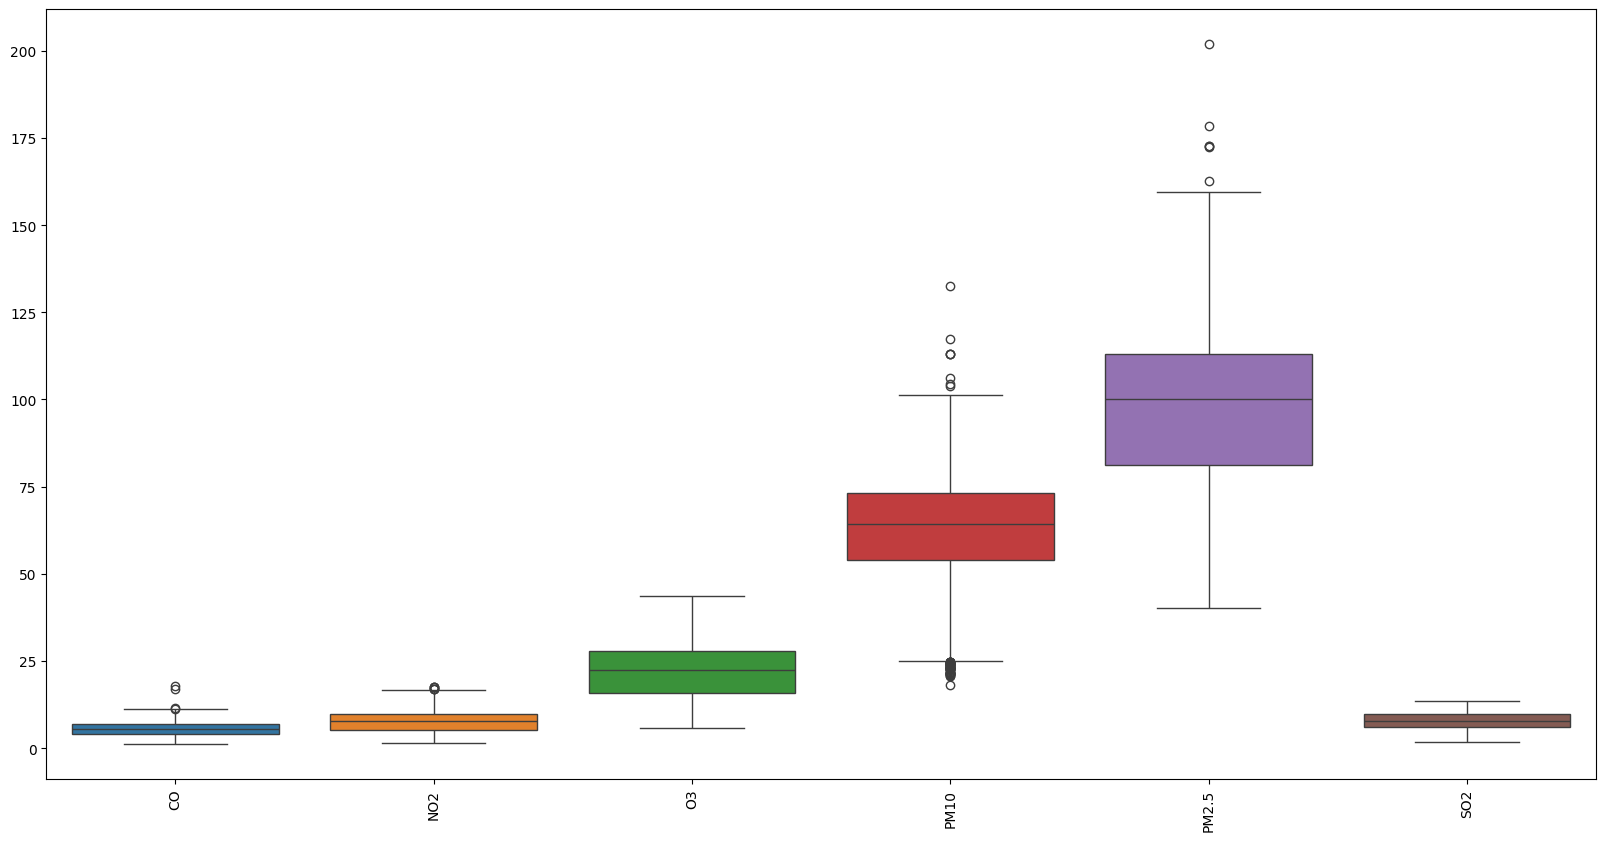

In [7]:
features = df_cleaned.drop(['Kategori'], axis=1) # dropping target
#Detecting outliers
plt.figure(figsize=(20,10))
sns.boxplot(data = features)
plt.xticks(rotation=90)
plt.show()

In [8]:
features = df_cleaned.drop(['Kategori'], axis=1) # dropping target

z_scores = np.abs(stats.zscore(features, nan_policy='omit'))
outliers_threshold = 3
mask = (z_scores < outliers_threshold).all(axis=1)
df_cleaned = df_cleaned[mask]

D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=f

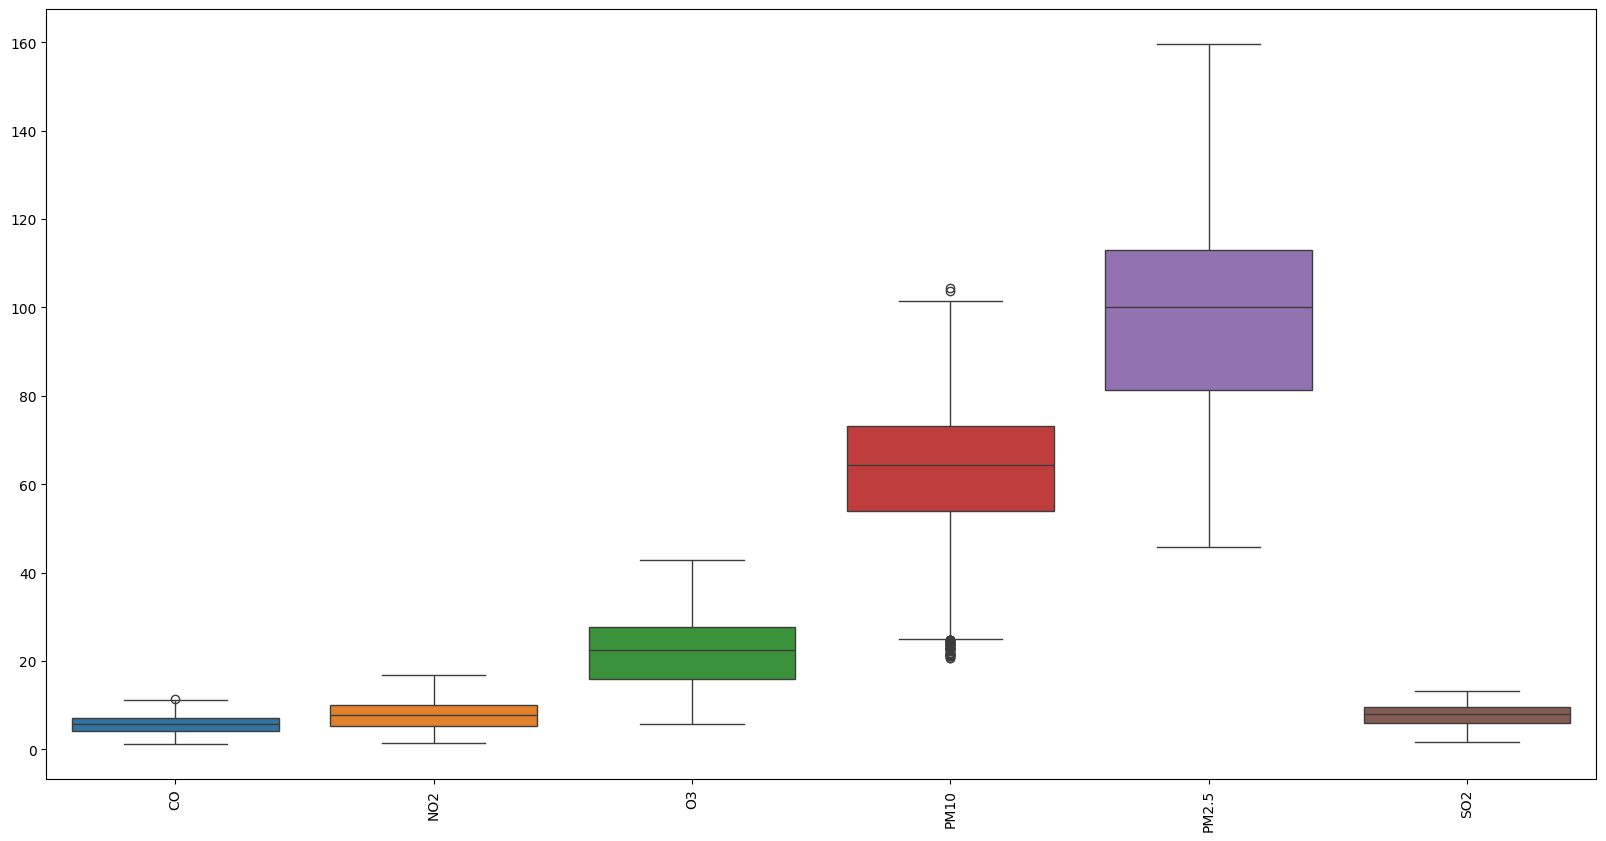

In [9]:
features = df_cleaned.drop(['Kategori'], axis=1) # dropping target
#Detecting outliers
plt.figure(figsize=(20,10))
sns.boxplot(data = features)
plt.xticks(rotation=90)
plt.show()

In [10]:
df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
CO,9838.0,5.649410,1.928056,1.194286,4.158929,5.623571,6.990000,11.270000
NO2,9838.0,7.761384,2.990846,1.500000,5.285714,7.785714,9.928571,16.714286
O3,9838.0,21.927444,7.167167,5.809524,15.904762,22.357143,27.761905,42.761905
PM10,9838.0,62.793002,14.343007,20.600000,53.850000,64.350000,73.137500,104.450000
PM2.5,9838.0,97.413511,20.886273,45.806452,81.328321,100.052632,113.052632,159.578947
SO2,9838.0,7.751531,2.461566,1.648352,5.934066,7.912088,9.670330,13.296703


In [11]:
df.Kategori.unique()

array(['SEDANG', 'TIDAK SEHAT', 'BAIK', 'SANGAT TIDAK SEHAT'],
      dtype=object)

In [12]:
#print("kolom =", df.Kategori.unique())

In [13]:
# Convert category to numeric
convert = {'BAIK': 1, 'SEDANG': 2, 'TIDAK SEHAT': 3, 'SANGAT TIDAK SEHAT' : 4}
df_cleaned['Kategori'] = df_cleaned['Kategori'].apply(lambda x: convert[x])
df_cleaned

C:\Users\siska\AppData\Local\Temp\ipykernel_22328\7860843.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Kategori'] = df_cleaned['Kategori'].apply(lambda x: convert[x])


,CO,NO2,O3,PM10,PM2.5,SO2,Kategori
0,1.730000,2.428571,12.380952,31.70,57.894737,2.417582,2
1,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,2
2,2.615714,4.857143,12.476190,47.20,71.929825,4.505495,2
3,2.608571,4.785714,12.428571,47.10,71.804511,4.395604,2
4,3.745714,5.142857,18.857143,57.35,87.468672,5.384615,2
...,...,...,...,...,...,...,...
9847,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,3
9848,7.762857,13.428571,27.095238,75.15,115.894737,11.428571,3
9849,7.755714,13.428571,27.095238,75.10,115.789474,11.428571,3
9850,9.004286,13.214286,27.428571,84.85,130.210526,11.868132,3


In [14]:
# Hitung jumlah kategori
unique_categories = df_cleaned['Kategori'].nunique()

# Cetak jumlah kategori
print(f"Jumlah kategori setelah konversi: {unique_categories}")

# Tampilkan kategori unik
categories = df_cleaned['Kategori'].unique()
print(f"Jenis Kategori: {categories}")

Jumlah kategori setelah konversi: 3
Jenis Kategori: [2 3 1]


### **Visualisasi data**

Grafik batang menunjukkan distribusi rata-rata tingkat polutan berdasarkan kategori polusi udara. Kategori polutan dikelompokkan menjadi beberapa jenis, seperti CO (Karbon Monoksida), NO₂ (Nitrogen Dioksida), O₃ (Ozon), PM10 (Partikulat dengan diameter ≤10µm), PM2.5 (Partikulat dengan diameter ≤2.5µm), dan SO₂ (Sulfur Dioksida).

C:\Users\siska\AppData\Local\Temp\ipykernel_22328\1925846291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_col, y=y_col, data=df_cleaned, palette=palette)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you wi

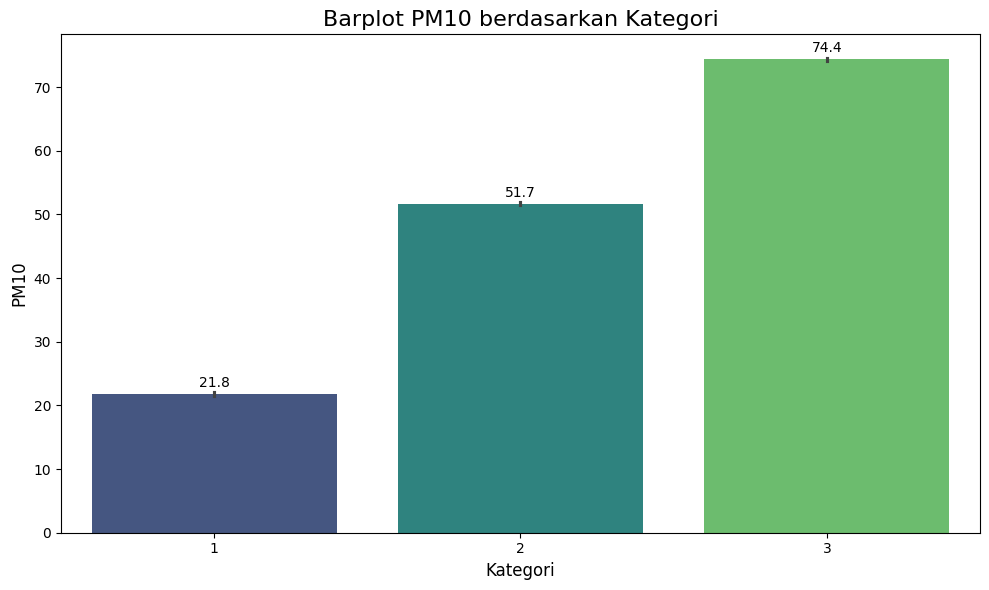

C:\Users\siska\AppData\Local\Temp\ipykernel_22328\1925846291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_col, y=y_col, data=df_cleaned, palette=palette)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you wi

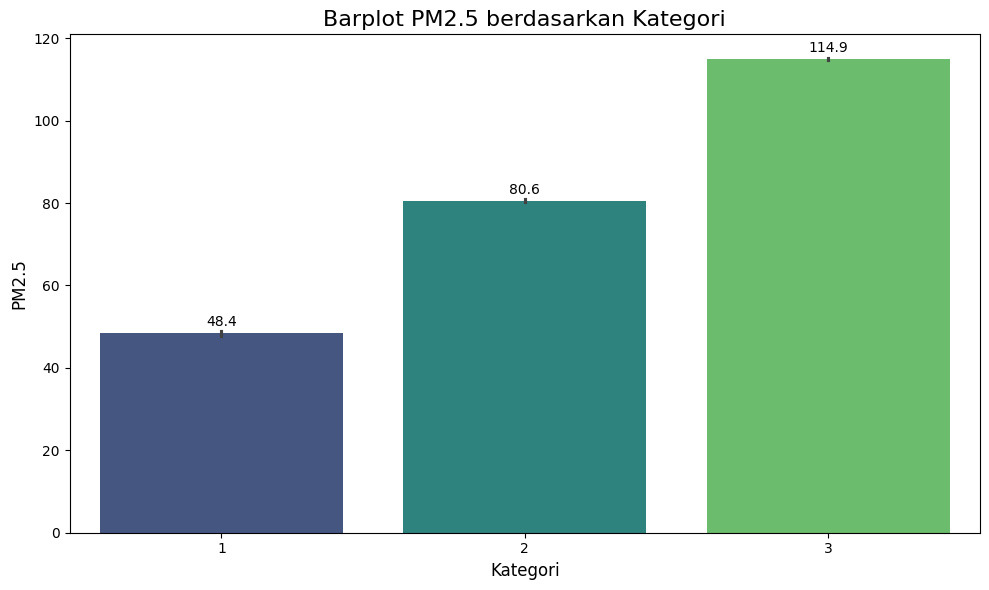

C:\Users\siska\AppData\Local\Temp\ipykernel_22328\1925846291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_col, y=y_col, data=df_cleaned, palette=palette)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you wi

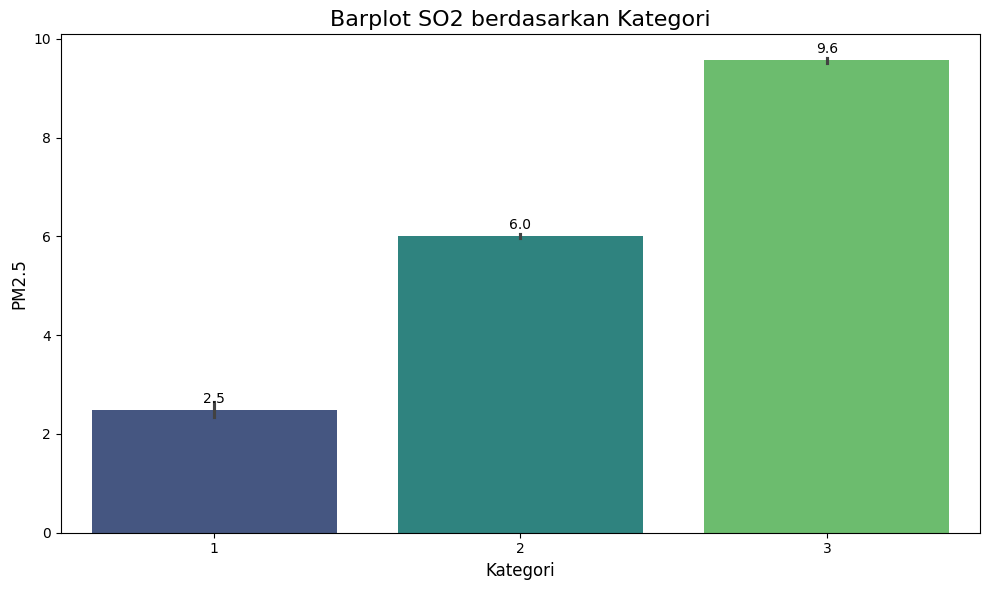

C:\Users\siska\AppData\Local\Temp\ipykernel_22328\1925846291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_col, y=y_col, data=df_cleaned, palette=palette)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you wi

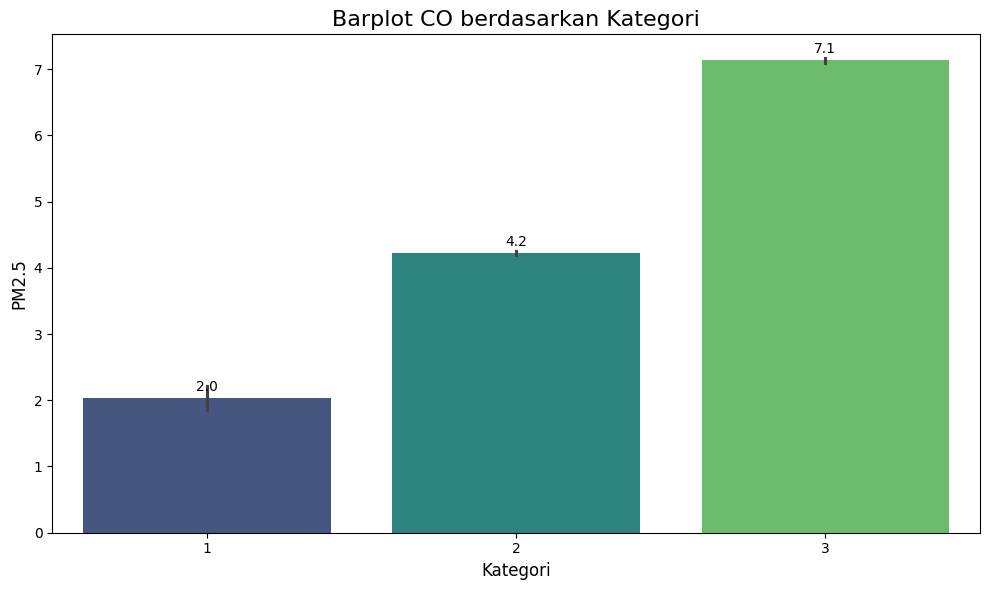

C:\Users\siska\AppData\Local\Temp\ipykernel_22328\1925846291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_col, y=y_col, data=df_cleaned, palette=palette)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you wi

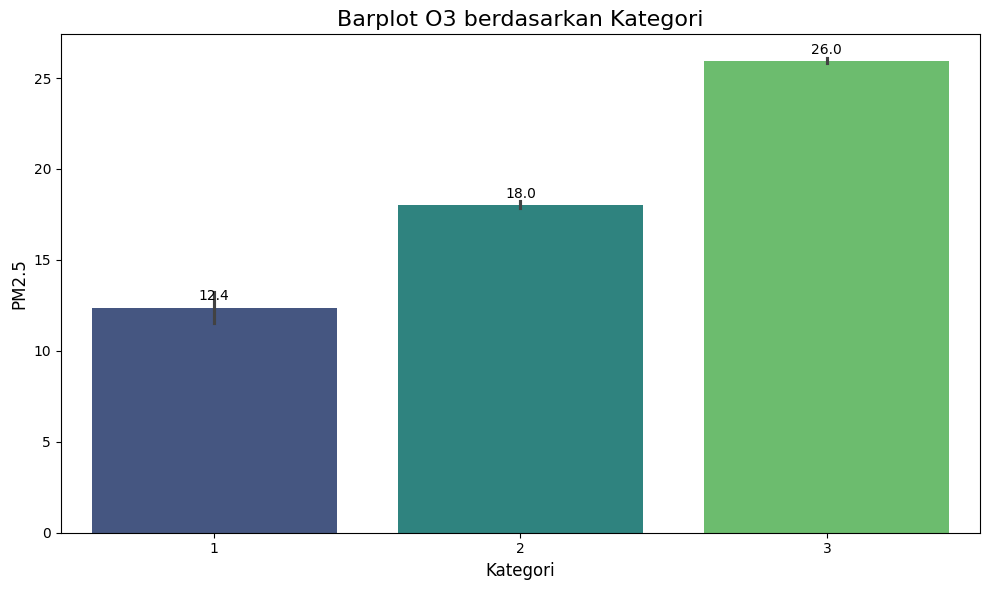

C:\Users\siska\AppData\Local\Temp\ipykernel_22328\1925846291.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_col, y=y_col, data=df_cleaned, palette=palette)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you wi

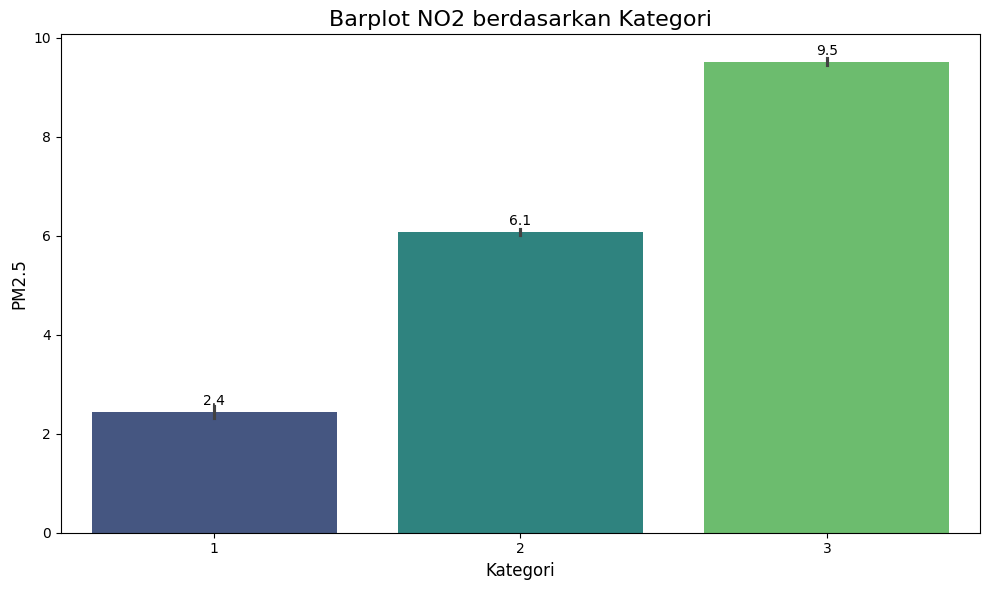

In [15]:
def plot_bar(data, x_col, y_col, title, xlabel, ylabel, palette='viridis'):
    """
    Fungsi untuk membuat barplot dengan anotasi angka di atasnya.
    """
    fig = plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=x_col, y=y_col, data=df_cleaned, palette=palette)
    
    # Menambahkan jumlah data di atas bar
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.1f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',  # Horizontal alignment
            va='center',  # Vertical alignment
            xytext=(0, 8),  # Offset teks dalam koordinat (x, y)
            textcoords='offset points'  # Koordinat berbasis offset
        )
    
    # Menambahkan judul dan label sumbu
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    # Menampilkan plot
    plt.tight_layout()
    plt.show()

# Visualisasi PM10
plot_bar(
    data=df_cleaned, 
    x_col='Kategori', 
    y_col='PM10', 
    title='Barplot PM10 berdasarkan Kategori', 
    xlabel='Kategori', 
    ylabel='PM10'
)

# Visualisasi PM2.5
plot_bar(
    data=df_cleaned, 
    x_col='Kategori', 
    y_col='PM2.5', 
    title='Barplot PM2.5 berdasarkan Kategori', 
    xlabel='Kategori', 
    ylabel='PM2.5'
)

# Visualisasi SO2
plot_bar(
    data=df_cleaned, 
    x_col='Kategori', 
    y_col='SO2', 
    title='Barplot SO2 berdasarkan Kategori', 
    xlabel='Kategori', 
    ylabel='PM2.5'
)


# Visualisasi CO
plot_bar(
    data=df_cleaned, 
    x_col='Kategori', 
    y_col='CO', 
    title='Barplot CO berdasarkan Kategori', 
    xlabel='Kategori', 
    ylabel='PM2.5'
)


# Visualisasi O3
plot_bar(
    data=df_cleaned, 
    x_col='Kategori', 
    y_col='O3', 
    title='Barplot O3 berdasarkan Kategori', 
    xlabel='Kategori', 
    ylabel='PM2.5'
)


# Visualisasi NO2
plot_bar(
    data=df_cleaned, 
    x_col='Kategori', 
    y_col='NO2', 
    title='Barplot NO2 berdasarkan Kategori', 
    xlabel='Kategori', 
    ylabel='PM2.5'
)


C:\Users\siska\AppData\Local\Temp\ipykernel_22328\2491432949.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = df['Kategori'], data = df_cleaned, palette='viridis')
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like

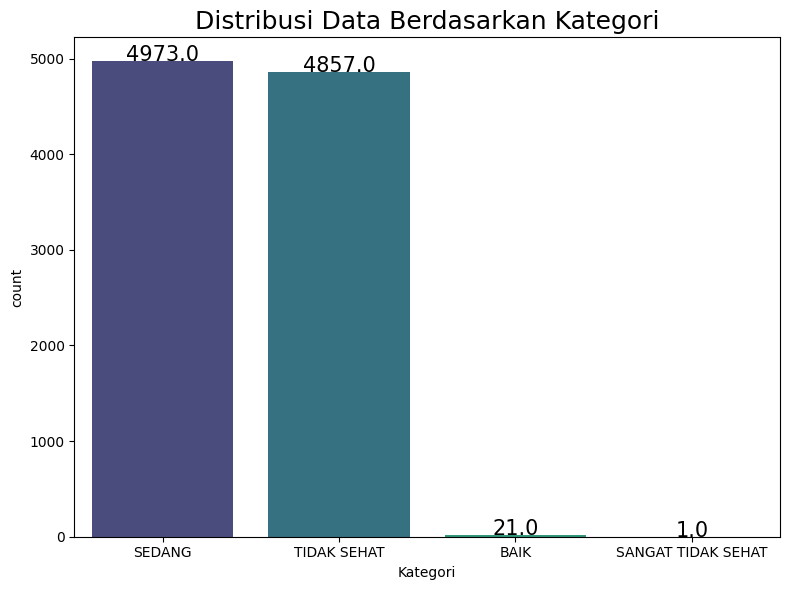

In [16]:
plt.figure(figsize=(8, 6))
plt.title("Distribusi Data Berdasarkan Kategori", fontsize = 18)
ax = sns.countplot(x = df['Kategori'], data = df_cleaned, palette='viridis')

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.7, rect.get_height(),
            horizontalalignment='center', fontsize=15)

plt.tight_layout()
plt.show()


In [17]:
#evaluasi target dan cari tahu apakah data seimbang atau tidak
#sns.countplot(x= df_cleaned['Kategori'])

D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple t

Text(0.5, 1.02, 'Multivariate Analysis Using Pairplots')

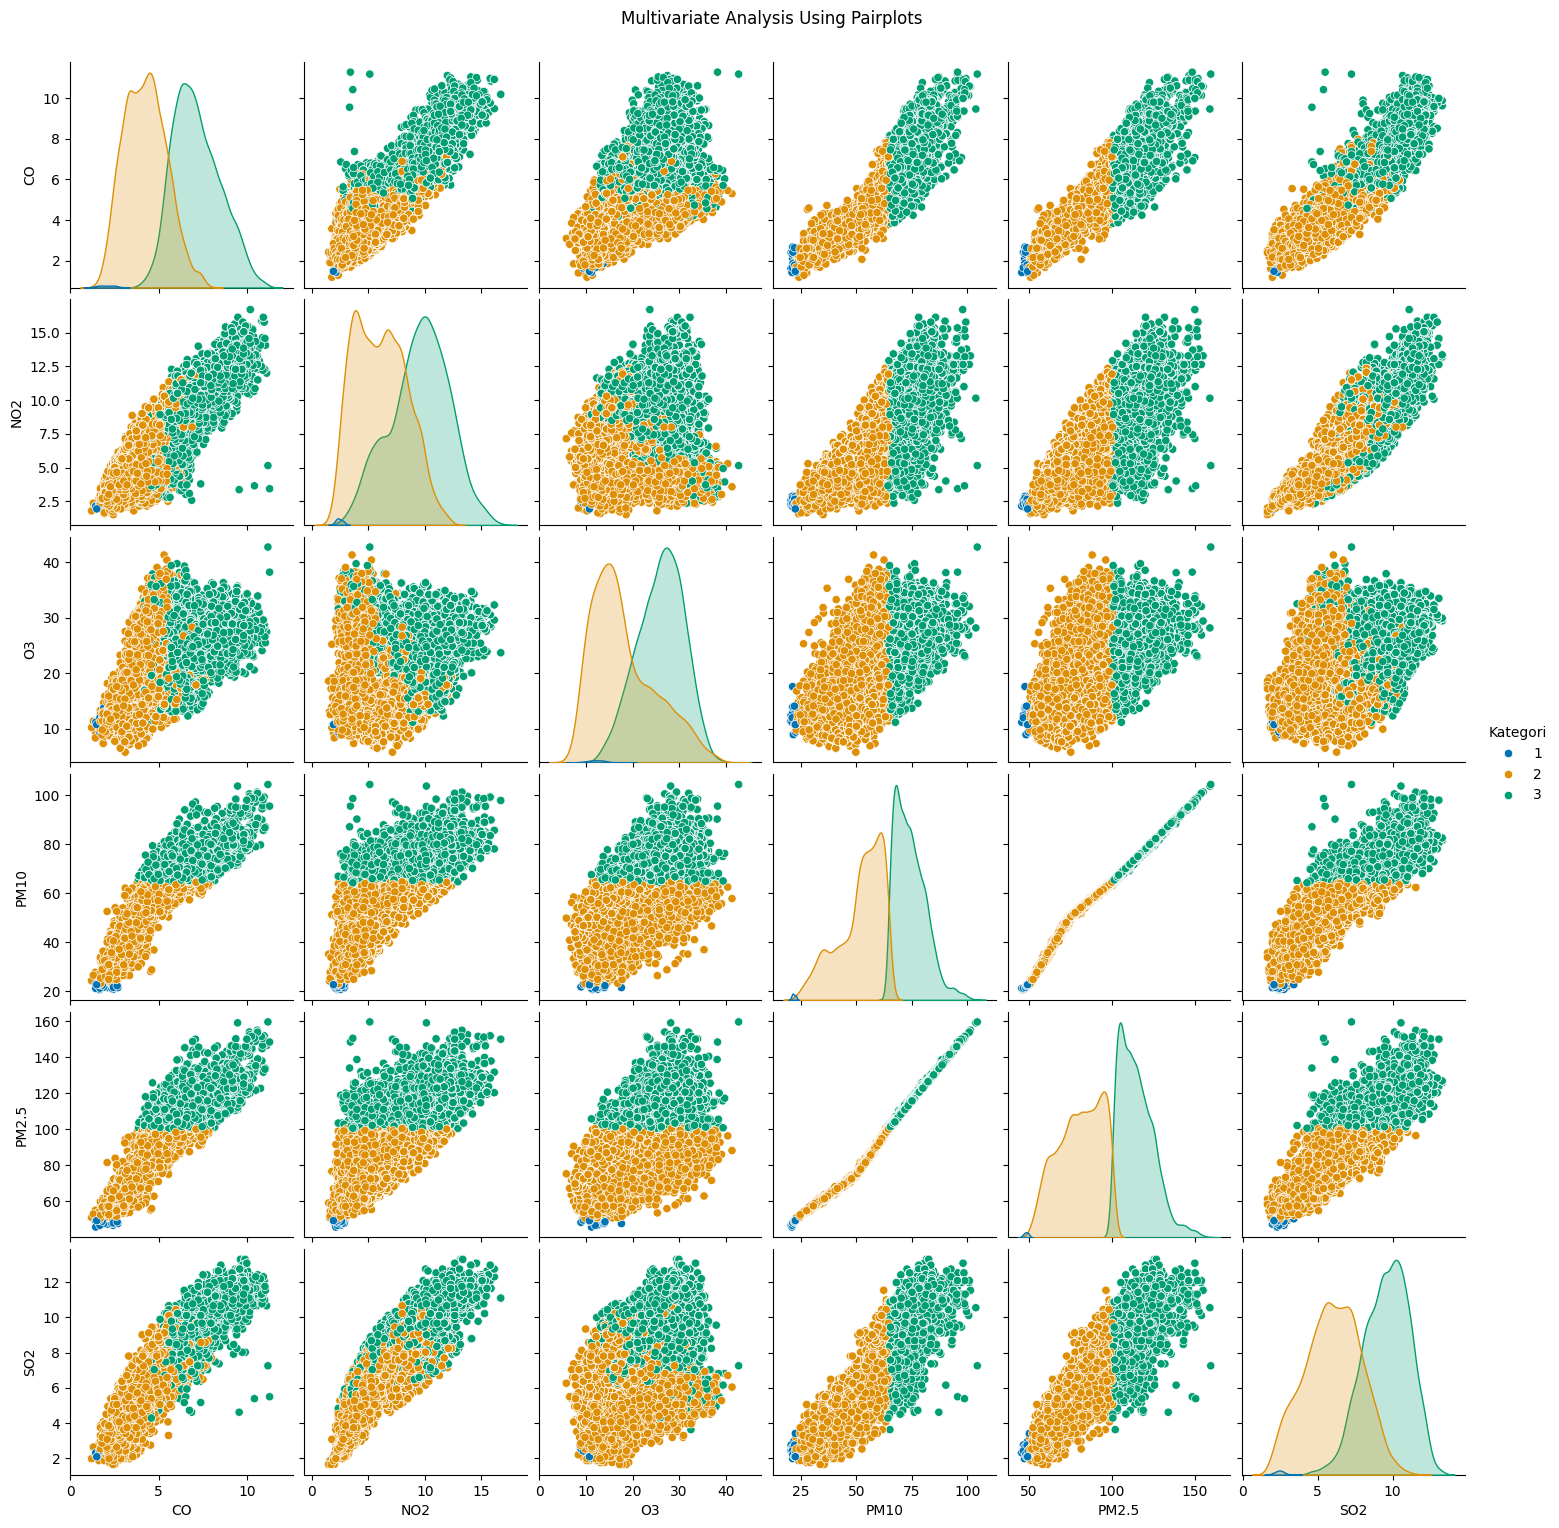

In [18]:
f = sns.pairplot(data=df_cleaned, hue = 'Kategori', kind='scatter', palette = "colorblind")
f.fig.suptitle('Multivariate Analysis Using Pairplots', y = 1.02)

<Axes: title={'center': "Pearson's Correlation Coefficient Using Heatmap"}>

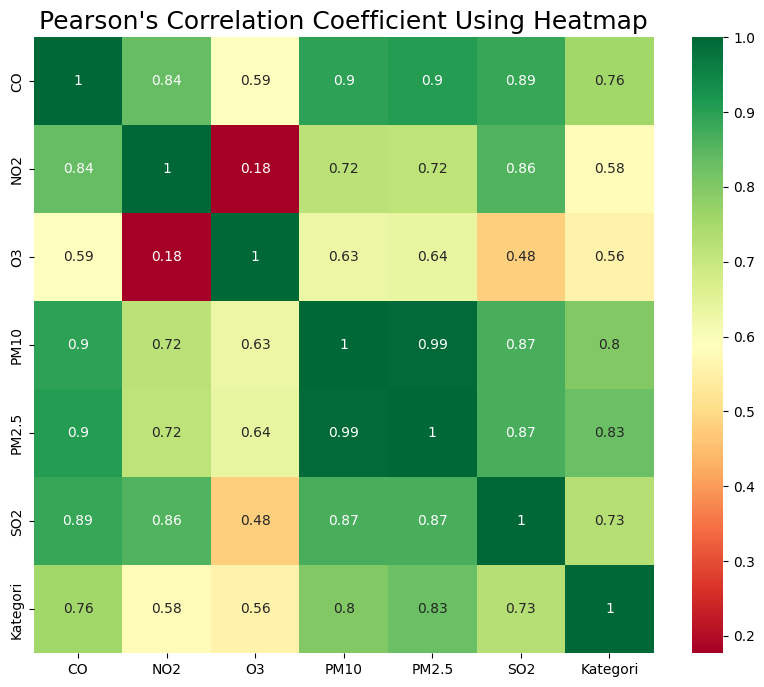

In [19]:
# Finding Pearson's Correlation Coefficient Using Heatmap
plt.figure(figsize=(10,8))
plt.title("Pearson's Correlation Coefficient Using Heatmap", fontsize = 18)
sns.heatmap(df_cleaned.corr(), annot=True, cmap ='RdYlGn')

<Axes: title={'center': 'Features Correlating with Categori'}>

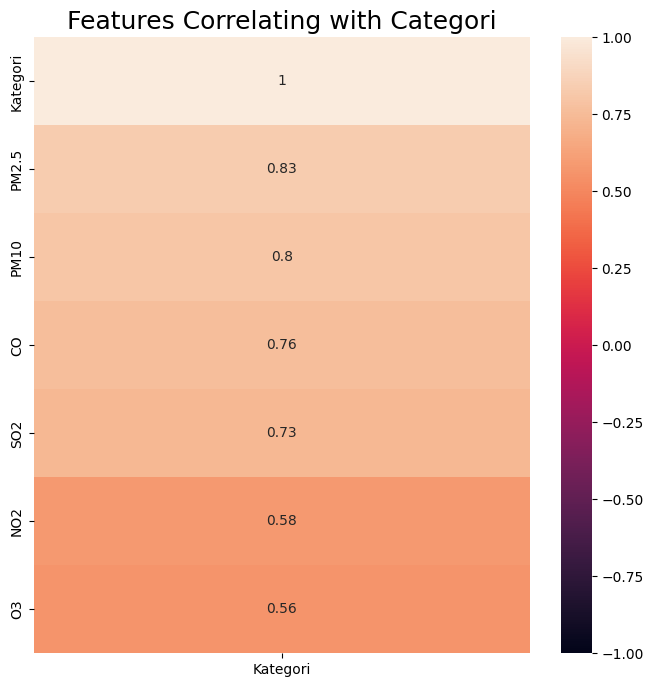

In [20]:
# Correlation
plt.figure(figsize=(8, 8))
plt.title("Features Correlating with Categori", fontsize = 18)
sns.heatmap(df_cleaned.corr()[['Kategori']].sort_values(by='Kategori', ascending=False), vmin=-1, vmax=1, annot=True)

**Mengatasi ketidakseimbangan data (data imbalance) adalah langkah penting dalam pemodelan yang dapat memengaruhi kinerja algoritma pembelajaran mesin, termasuk metode Support Vector Machine (SVM). Salah satu teknik yang digunakan untuk mengatasi ketidakseimbangan data adalah SMOTE (Synthetic Minority Over-sampling Technique).**

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Pisahkan dataset sebagai variabel respons dan variabel fitur

In [22]:
X = df_cleaned.iloc[:, 0:5].values
y = df_cleaned.iloc[:, 6].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [24]:
from imblearn.over_sampling import SMOTE
# Inisialisasi SMOTE
smote = SMOTE()

# Oversampling pada data pelatihan
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## **Klasifikasi Sebelum Optimasi Menggunakan Hyperparameter**

In [25]:
# train the model on train set
model = SVC()
model.fit(X_train_resampled, y_train_resampled)
  
# print prediction results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.35      1.00      0.52         8
           2       1.00      0.99      0.99      1291
           3       1.00      1.00      1.00      1161

    accuracy                           0.99      2460
   macro avg       0.78      0.99      0.84      2460
weighted avg       1.00      0.99      0.99      2460



In [26]:
# Evaluasi model
# Lakukan prediksi pada data pengujian
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.991869918699187


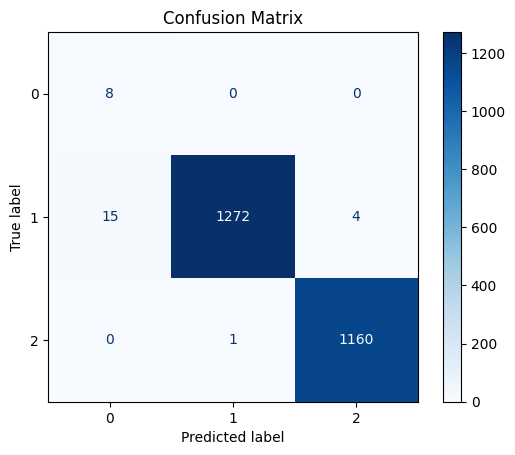

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tampilkan Confusion Matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## **Klasifikasi Setelah Optimasi Menggunakan Hyperparameter GridSearchCV**

In [28]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'C': [0.1, 1, 100, 1000],
    'kernel': ['rbf', 'poly', 'linear'],
    'degree': [1, 2, 3, 4, 5, 6]
}

grid=GridSearchCV(SVC(),param_grid)

random_search = RandomizedSearchCV(
    SVC(),
    param_distributions=param_grid,
    n_iter=20,  # Jumlah iterasi acak
    random_state=42,
    cv=3  # Jumlah lipatan validasi silang
)
random_search.fit(X_train, y_train)

# Cetak hasil
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


Best Parameters: {'kernel': 'linear', 'degree': 3, 'C': 1000}
Best Score: 0.9995933306222042


In [29]:
# Lakukan prediksi menggunakan model terbaik dari GridSearchCV
grid_predictions = random_search.predict(X_test)

# Cetak laporan klasifikasi
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00      1291
           3       1.00      1.00      1.00      1161

    accuracy                           1.00      2460
   macro avg       1.00      1.00      1.00      2460
weighted avg       1.00      1.00      1.00      2460



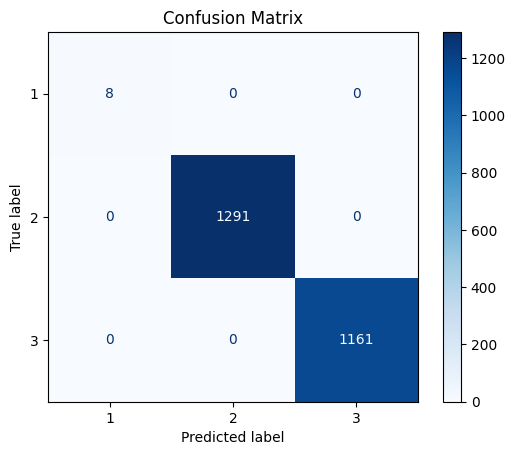

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hasil prediksi menggunakan model terbaik
grid_predictions = random_search.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, grid_predictions)

labels = np.unique(y_test) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## **Pengecekan jumlah data berdasarkan kategori menggunakan model klasifikasi yang telah dioptimasi**

In [31]:
full_predictions = random_search.best_estimator_.predict(X)
user_category = int(input("Masukkan kategori (misalnya 1, 2, 3, atau 4): "))
category_count = (full_predictions == user_category).sum()
print(f"Jumlah data dengan kategori {user_category}: {category_count} dari total {len(full_predictions)} data.")


Jumlah data dengan kategori 1: 20 dari total 9838 data.


In [32]:
# Prediksi seluruh data menggunakan model terbaik dari random search
full_predictions = random_search.best_estimator_.predict(X)

# Hitung jumlah data untuk setiap kategori
categories, counts = np.unique(full_predictions, return_counts=True)

# Tampilkan jumlah data untuk setiap kategori
print("Jumlah data berdasarkan kategori:")
print("=" * 40)
for category, count in zip(categories, counts):
    print(f"Kategori {category}: {count} data")
    print("-" * 40)

# Total data
print(f"Total data: {len(full_predictions)}")

Jumlah data berdasarkan kategori:
Kategori 1: 20 data
----------------------------------------
Kategori 2: 4973 data
----------------------------------------
Kategori 3: 4845 data
----------------------------------------
Total data: 9838
